# 实验一：支持向量机--UCI数据集Iris

支持向量机有两种：SVC，支持向量分类，用于分类问题；SVR,支持向量回归，用于回归问题。

In [1]:
# 作者：爱夏<843573616@qq.com>
# 时间：2018年9月5日
%pylab inline
import numpy as np
import pylab as pl

Populating the interactive namespace from numpy and matplotlib


In [2]:
from sklearn import svm

## 线性支持向量机（Linear SVMs）:简单认识

我们采用一个非常有名的UCI数据集用于分类问题：鸢尾花数据集。
它是基于鸢尾花的花萼的长度和宽度;花瓣长度和宽度 4个特征进行分类的。我们只用其中两维特征，这能够方便可视化。

In [3]:
svc = svm.SVC(kernel='linear')
# 鸢尾花数据集是sklearn自带的。
from sklearn import datasets
iris = datasets.load_iris()
# 只提取前面两列数据作为特征
X = iris.data[:, :2]
y = iris.target
# 基于这些数据训练出一个支持向量分离器SVC
svc.fit(X, y)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [4]:
from matplotlib.colors import ListedColormap
# 因为鸢尾花是3分类问题，我们要对样本和预测结果均用三种颜色区分开。
cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])

def plot_estimator(estimator, X, y):
    '''
    这个函数的作用是基于分类器，对预测结果与原始标签进行可视化。
    '''
    estimator.fit(X, y)
    # 确定网格最大最小值作为边界
    x_min, x_max = X[:, 0].min() - .1, X[:, 0].max() + .1
    y_min, y_max = X[:, 1].min() - .1, X[:, 1].max() + .1
    # 产生网格节点
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                         np.linspace(y_min, y_max, 100))
    # 基于分离器，对网格节点做预测
    Z = estimator.predict(np.c_[xx.ravel(), yy.ravel()])

    # 对预测结果上色
    Z = Z.reshape(xx.shape)
    pl.figure()
    pl.pcolormesh(xx, yy, Z, cmap=cmap_light)

    # 同时对原始训练样本上色
    pl.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap_bold)
    pl.axis('tight')
    pl.axis('off')
    pl.tight_layout()

将预测结果可视化

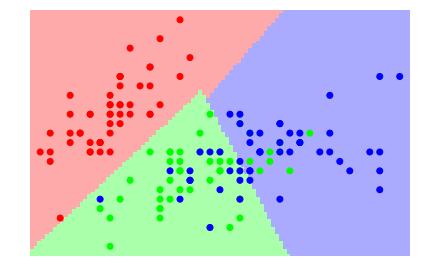

In [5]:
plot_estimator(svc, X, y)

* 正如我们所见，`kernel="linear"`（线性核函数）给了我们线性的决策边界：两类之间的分离边界是直线。
* 多分类的工作方式就是"one versus one" ：在任意两类样本之间设计一个SVM，因此k个类别的样本就需要设计k(k-1)/2个SVM。当对一个未知样本进行分类时，最后得票最多的类别即为该未知样本的类别。
* **线性支持向量分类器（LinearSVC）**：对于线性核函数，有一个新的对象`LinearSVC` ，它使用了不同的算法。它对于多分类采用的是"one versus all"策略。

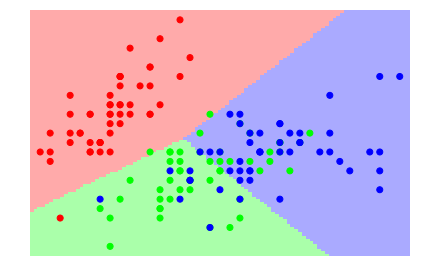

In [6]:
plot_estimator(svm.LinearSVC(), X, y)

Text(0.5,1,'Low C values: high number of support vectors')

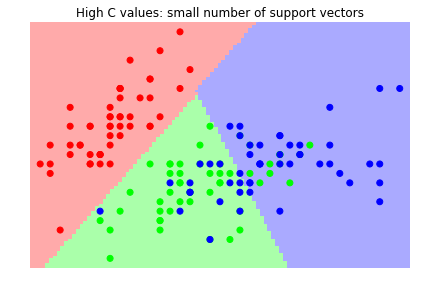

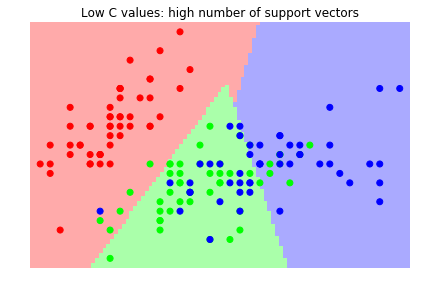

In [7]:
svc = svm.SVC(kernel='linear', C=1e3)
plot_estimator(svc, X, y)
pl.scatter(svc.support_vectors_[:, 0], svc.support_vectors_[:, 1], s=80, facecolors='none', zorder=10)
pl.title('High C values: small number of support vectors')

svc = svm.SVC(kernel='linear', C=1e-3)
plot_estimator(svc, X, y)
pl.scatter(svc.support_vectors_[:, 0], svc.support_vectors_[:, 1], s=80, facecolors='none', zorder=10)
pl.title('Low C values: high number of support vectors')

## 支持向量与正则化

* **正则化** ：只考虑支持向量其实就是一种正则化的形式。实际上，它强迫模型在处理样本特征的时候变得更加简单。
This regularization can be tuned with the *C* parameter:
* 正则项可以通过调整系数 *C* 来决定：
  - 小的C值：将会有很多支持向量。决策边界=类别A的平均值-类别B的平均值
  - 大的C值：将会有较少的支持向量。决策边界是被大多数支持向量所决定。

* **支持向量**：就是最靠近分离边界的样本点。支持向量机的工作方式就是找到这些支持向量，它们被认为是在二分类问题中最具代表性的样本点。
* 为了更方便的可视化，我们选择二分类问题，也就是只考虑鸢尾花数据集中的1类和2类样本。这两类不是线性可分的，所以我们可以看到更有趣的一些东西。
* 支持向量的坐标可以通过方法`support_vectors_`来找到。我们在图中将对它们着重标记。

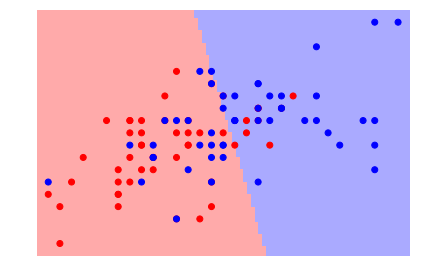

In [8]:
X, y = X[np.in1d(y, [1, 2])], y[np.in1d(y, [1, 2])]
plot_estimator(svc, X, y)
pl.scatter(svc.support_vectors_[:, 0], svc.support_vectors_[:, 1], s=80, facecolors='none', zorder=10)

* 支持向量机的有个好处是对于许多数据集，默认参数'C=1'其实工作得很好。
* **实践经验：对样本正则化**： 对于许多分离器，采用标准差正则方法是非常重要的提升预测效果的手段。

## 核方法

采用核方法，能够很方便地产生非线性分类边界。

- **linear**，线性核，会产生线性分类边界。一般来说它的计算效率最高，而且需要数据最少。
- **poly** ，多项式核，会产生多项式分类边界。
- **rbf**，径向基函数，也就是高斯核，是根据与每一个支持向量的距离来决定分类边界的。它的映射到无线维的。它是最灵活的方法，但是也需要最多的数据。

Text(0.5,1,'RBF kernel')

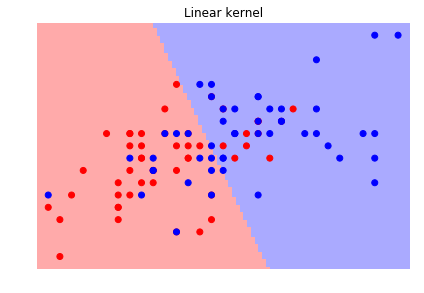

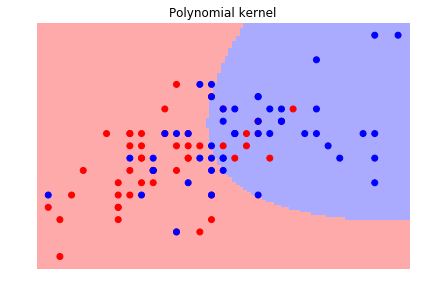

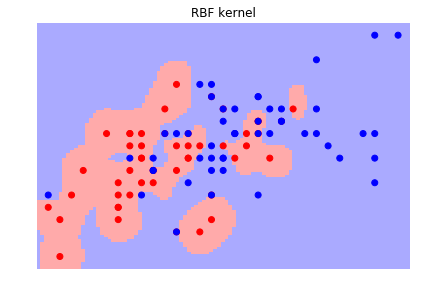

In [9]:
svc = svm.SVC(kernel='linear')
plot_estimator(svc, X, y)
pl.scatter(svc.support_vectors_[:, 0], svc.support_vectors_[:, 1], s=80, facecolors='none', zorder=10)
pl.title('Linear kernel')

svc = svm.SVC(kernel='poly', degree=4)
plot_estimator(svc, X, y)
pl.scatter(svc.support_vectors_[:, 0], svc.support_vectors_[:, 1], s=80, facecolors='none', zorder=10)
pl.title('Polynomial kernel')

svc = svm.SVC(kernel='rbf', gamma=1e2)
plot_estimator(svc, X, y)
pl.scatter(svc.support_vectors_[:, 0], svc.support_vectors_[:, 1], s=80, facecolors='none', zorder=10)
pl.title('RBF kernel')

我们可以看到，高斯核更灵活，而且对于训练数据效果是最好的。但是要担心过拟合。

# 实验二：SMO算法实现

首先我们把SVM对偶问题的求解目标再次写下来。
优化目标 (软间隔的对偶问题):
$$\newcommand{\argmin}{\mathop{\rm arg~min}\limits}
\argmin_{\alpha_n} \varphi ＝ ( \frac{1}{2} \sum_{n=1}^N \sum_{m=1}^N \alpha_n\alpha_my_ny_mK(x_n,x_m) - \sum_{n=1}^N \alpha_n )
约束条件:
$$C\geq\alpha_n\geq0\
$$\sum_{n=1}^N \alpha_ny_n = 0

In [1]:
# 作者：爱夏<843573616@qq.com>
# 时间：2018年9月6日
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

%config InlineBackend.figure_format = 'retina'

from sklearn.datasets import make_blobs, make_circles, make_moons
from sklearn.preprocessing import StandardScaler

In [2]:
#初始化模型参数
class SMOModel:
    """sequential minimal optimization."""
    
    def __init__(self, X, y, C, kernel, alphas, b, errors):
        self.X = X               # training data vector
        self.y = y               # class label vector
        self.C = C               # regularization parameter
        self.kernel = kernel     # kernel function
        self.alphas = alphas     # lagrange multiplier vector
        self.b = b               # scalar bias term
        self.errors = errors     # error cache
        self._obj = []           # record of objective function value
        self.m = len(self.X)     # store size of training set

定义线性核和高斯核
$$K(x,z) = x^Tz + b
$$K(x,z) = exp\left(\frac{-\lvert x - z\rvert^2}{2\sigma^2}\right)

In [3]:
def linear_kernel(x, y, b=1):
    """Returns the linear combination of arrays `x` and `y` with
    the optional bias term `b` (set to 1 by default)."""
    
    return x @ y.T + b # Note the @ operator for matrix multiplication


def gaussian_kernel(x, y, sigma=1):
    """Returns the gaussian similarity of arrays `x` and `y` with
    kernel width parameter `sigma` (set to 1 by default)."""
    
    if np.ndim(x) == 1 and np.ndim(y) == 1:
        result = np.exp(- np.linalg.norm(x - y) / (2 * sigma ** 2))
    elif (np.ndim(x) > 1 and np.ndim(y) == 1) or (np.ndim(x) == 1 and np.ndim(y) > 1):
        result = np.exp(- np.linalg.norm(x - y, axis=1) / (2 * sigma ** 2))
    elif np.ndim(x) > 1 and np.ndim(y) > 1:
        result = np.exp(- np.linalg.norm(x[:, np.newaxis] - y[np.newaxis, :], axis=2) / (2 * sigma ** 2))
    return result

In [4]:
x_len, y_len = 5, 10
linear_kernel(np.random.rand(x_len, 1), np.random.rand(y_len, 1)).shape == (x_len,y_len)
gaussian_kernel(np.random.rand(x_len, 1), np.random.rand(y_len, 1)).shape == (5,10)

True

In [5]:
# Objective function to optimize

def objective_function(alphas, target, kernel, X_train):
    """Returns the SVM objective function based in the input model defined by:
    `alphas`: vector of Lagrange multipliers
    `target`: vector of class labels (-1 or 1) for training data
    `kernel`: kernel function
    `X_train`: training data for model."""
    
    return np.sum(alphas) - 0.5 * np.sum(target * target * kernel(X_train, X_train) * alphas * alphas)


# Decision function

def decision_function(alphas, target, kernel, X_train, x_test, b):
    """Applies the SVM decision function to the input feature vectors in `x_test`."""
    
    result = (alphas * target) @ kernel(X_train, x_test) - b
    return result

In [6]:
def plot_decision_boundary(model, ax, resolution=100, colors=('b', 'k', 'r')):
        """Plots the model's decision boundary on the input axes object.
        Range of decision boundary grid is determined by the training data.
        Returns decision boundary grid and axes object (`grid`, `ax`)."""
        
        # Generate coordinate grid of shape [resolution x resolution]
        # and evaluate the model over the entire space
        xrange = np.linspace(model.X[:,0].min(), model.X[:,0].max(), resolution)
        yrange = np.linspace(model.X[:,1].min(), model.X[:,1].max(), resolution)
        grid = [[decision_function(model.alphas, model.y,
                                   model.kernel, model.X,
                                   np.array([xr, yr]), model.b) for yr in yrange] for xr in xrange]
        grid = np.array(grid).reshape(len(xrange), len(yrange))
        
        # Plot decision contours using grid and
        # make a scatter plot of training data
        ax.contour(xrange, yrange, grid, (-1, 0, 1), linewidths=(1, 1, 1),
                   linestyles=('--', '-', '--'), colors=colors)
        ax.scatter(model.X[:,0], model.X[:,1],
                   c=model.y, cmap=plt.cm.viridis, lw=0, alpha=0.5)
        
        # Plot support vectors (non-zero alphas)
        # as circled points (linewidth > 0)
        mask = model.alphas != 0.0
        ax.scatter(model.X[:,0][mask], model.X[:,1][mask],
                   c=model.y[mask], cmap=plt.cm.viridis)
        
        return grid, ax

In [7]:
def take_step(i1, i2, model):
    
    # Skip if chosen alphas are the same
    if i1 == i2:
        return 0, model
    
    alph1 = model.alphas[i1]
    alph2 = model.alphas[i2]
    y1 = model.y[i1]
    y2 = model.y[i2]
    E1 = model.errors[i1]
    E2 = model.errors[i2]
    s = y1 * y2
    
    # Compute L & H, the bounds on new possible alpha values
    if (y1 != y2):
        L = max(0, alph2 - alph1)
        H = min(model.C, model.C + alph2 - alph1)
    elif (y1 == y2):
        L = max(0, alph1 + alph2 - model.C)
        H = min(model.C, alph1 + alph2)
    if (L == H):
        return 0, model

    # Compute kernel & 2nd derivative eta
    k11 = model.kernel(model.X[i1], model.X[i1])
    k12 = model.kernel(model.X[i1], model.X[i2])
    k22 = model.kernel(model.X[i2], model.X[i2])
    eta = 2 * k12 - k11 - k22
    
    # Compute new alpha 2 (a2) if eta is negative
    if (eta < 0):
        a2 = alph2 - y2 * (E1 - E2) / eta
        # Clip a2 based on bounds L & H
        if L < a2 < H:
            a2 = a2
        elif (a2 <= L):
            a2 = L
        elif (a2 >= H):
            a2 = H
            
    # If eta is non-negative, move new a2 to bound with greater objective function value
    else:
        alphas_adj = model.alphas.copy()
        alphas_adj[i2] = L
        # objective function output with a2 = L
        Lobj = objective_function(alphas_adj, model.y, model.kernel, model.X) 
        alphas_adj[i2] = H
        # objective function output with a2 = H
        Hobj = objective_function(alphas_adj, model.y, model.kernel, model.X)
        if Lobj > (Hobj + eps):
            a2 = L
        elif Lobj < (Hobj - eps):
            a2 = H
        else:
            a2 = alph2
            
    # Push a2 to 0 or C if very close
    if a2 < 1e-8:
        a2 = 0.0
    elif a2 > (model.C - 1e-8):
        a2 = model.C
    
    # If examples can't be optimized within epsilon (eps), skip this pair
    if (np.abs(a2 - alph2) < eps * (a2 + alph2 + eps)):
        return 0, model
    
    # Calculate new alpha 1 (a1)
    a1 = alph1 + s * (alph2 - a2)
    
    # Update threshold b to reflect newly calculated alphas
    # Calculate both possible thresholds
    b1 = E1 + y1 * (a1 - alph1) * k11 + y2 * (a2 - alph2) * k12 + model.b
    b2 = E2 + y1 * (a1 - alph1) * k12 + y2 * (a2 - alph2) * k22 + model.b
    
    # Set new threshold based on if a1 or a2 is bound by L and/or H
    if 0 < a1 and a1 < C:
        b_new = b1
    elif 0 < a2 and a2 < C:
        b_new = b2
    # Average thresholds if both are bound
    else:
        b_new = (b1 + b2) * 0.5

    # Update model object with new alphas & threshold
    model.alphas[i1] = a1
    model.alphas[i2] = a2
    
    # Update error cache
    # Error cache for optimized alphas is set to 0 if they're unbound
    for index, alph in zip([i1, i2], [a1, a2]):
        if 0.0 < alph < model.C:
            model.errors[index] = 0.0
    
    # Set non-optimized errors based on equation 12.11 in Platt's book
    non_opt = [n for n in range(model.m) if (n != i1 and n != i2)]
    model.errors[non_opt] = model.errors[non_opt] + \
                            y1*(a1 - alph1)*model.kernel(model.X[i1], model.X[non_opt]) + \
                            y2*(a2 - alph2)*model.kernel(model.X[i2], model.X[non_opt]) + model.b - b_new
    
    # Update model threshold
    model.b = b_new
    
    return 1, model

In [8]:
def examine_example(i2, model):
    
    y2 = model.y[i2]
    alph2 = model.alphas[i2]
    E2 = model.errors[i2]
    r2 = E2 * y2

    # Proceed if error is within specified tolerance (tol)
    if ((r2 < -tol and alph2 < model.C) or (r2 > tol and alph2 > 0)):
        
        if len(model.alphas[(model.alphas != 0) & (model.alphas != model.C)]) > 1:
            # Use 2nd choice heuristic is choose max difference in error
            if model.errors[i2] > 0:
                i1 = np.argmin(model.errors)
            elif model.errors[i2] <= 0:
                i1 = np.argmax(model.errors)
            step_result, model = take_step(i1, i2, model)
            if step_result:
                return 1, model
            
        # Loop through non-zero and non-C alphas, starting at a random point
        for i1 in np.roll(np.where((model.alphas != 0) & (model.alphas != model.C))[0],
                          np.random.choice(np.arange(model.m))):
            step_result, model = take_step(i1, i2, model)
            if step_result:
                return 1, model
        
        # loop through all alphas, starting at a random point
        for i1 in np.roll(np.arange(model.m), np.random.choice(np.arange(model.m))):
            step_result, model = take_step(i1, i2, model)
            if step_result:
                return 1, model
    
    return 0, model

In [9]:
def train(model):
    
    numChanged = 0
    examineAll = 1

    while(numChanged > 0) or (examineAll):
        numChanged = 0
        if examineAll:
            # loop over all training examples
            for i in range(model.alphas.shape[0]):
                examine_result, model = examine_example(i, model)
                numChanged += examine_result
                if examine_result:
                    obj_result = objective_function(model.alphas, model.y, model.kernel, model.X)
                    model._obj.append(obj_result)
        else:
            # loop over examples where alphas are not already at their limits
            for i in np.where((model.alphas != 0) & (model.alphas != model.C))[0]:
                examine_result, model = examine_example(i, model)
                numChanged += examine_result
                if examine_result:
                    obj_result = objective_function(model.alphas, model.y, model.kernel, model.X)
                    model._obj.append(obj_result)
        if examineAll == 1:
            examineAll = 0
        elif numChanged == 0:
            examineAll = 1
        
    return model

In [10]:
X_train, y = make_blobs(n_samples=1000, centers=2,
                        n_features=2, random_state=1)

In [15]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train, y)

In [16]:
y[y == 0] = -1

In [17]:
# Set model parameters and initial values
C = 1000.0
m = len(X_train_scaled)
initial_alphas = np.zeros(m)
initial_b = 0.0

# Set tolerances
tol = 0.01 # error tolerance
eps = 0.01 # alpha tolerance

# Instantiate model
model = SMOModel(X_train_scaled, y, C, linear_kernel,
                 initial_alphas, initial_b, np.zeros(m))

# Initialize error cache
initial_error = decision_function(model.alphas, model.y, model.kernel,
                                  model.X, model.X, model.b) - model.y
model.errors = initial_error

In [18]:
np.random.seed(0)
output = train(model)

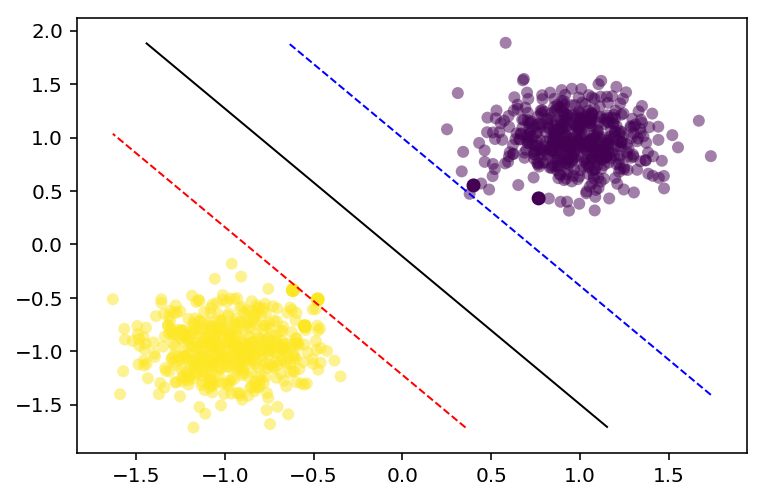

In [19]:
fig, ax = plt.subplots()
grid, ax = plot_decision_boundary(output, ax)

In [20]:
output.alphas[output.alphas != 0]

array([1.09686137e+00, 1.38777878e-17, 2.77555756e-17, 2.22050604e-02,
       1.07465631e+00])

In [27]:
# Add an outlier
X_outlier = np.append(X_train_scaled, [0.1, 0.1])
X_outlier = X_outlier.reshape(X_train.shape[0]+1, X_train.shape[1])
y_outlier = np.append(y, 1)

In [28]:
# Set model parameters and initial values
C = 100.0
m = len(X_outlier)
initial_alphas = np.zeros(m)
initial_b = 0.0
# Set tolerances
tol = 0.01 # error tolerance
eps = 0.01 # alpha tolerance
# Instantiate model
model = SMOModel(X_outlier, y_outlier, C, linear_kernel,
                 initial_alphas, initial_b, np.zeros(m))

# Initialize error cache
initial_error = decision_function(model.alphas, model.y, model.kernel,
                                  model.X, model.X, model.b) - model.y
model.errors = initial_error

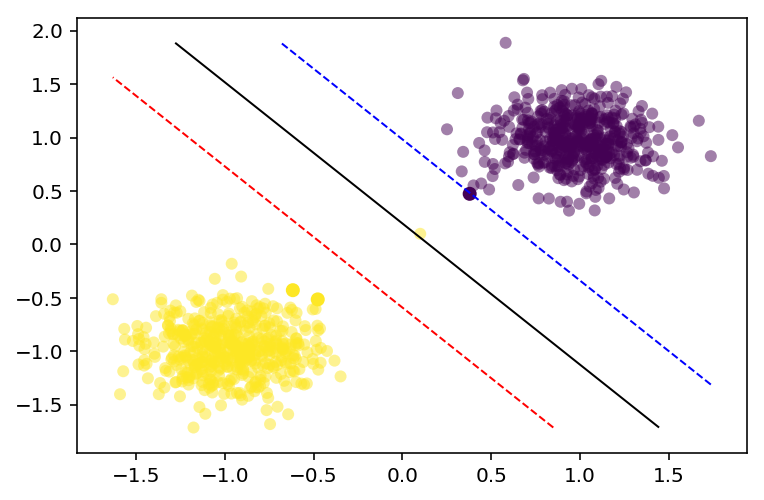

In [29]:
output = train(model)
fig, ax = plt.subplots()
grid, ax = plot_decision_boundary(output, ax)

In [30]:
# Set model parameters and initial values
C = 1.0

initial_alphas = np.zeros(m)
initial_b = 0.0

# Instantiate model
model = SMOModel(X_outlier, y_outlier, C, linear_kernel,
                 initial_alphas, initial_b, np.zeros(m))

# Initialize error cache
initial_error = decision_function(model.alphas, model.y, model.kernel,
                                  model.X, model.X, model.b) - model.y
model.errors = initial_error

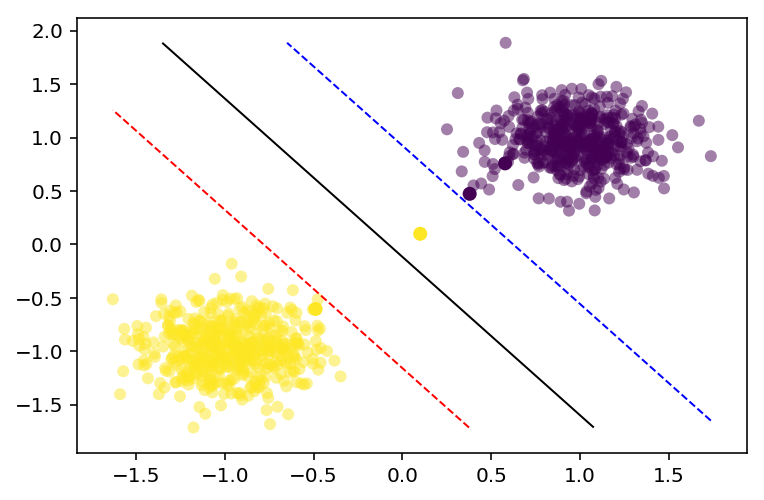

In [31]:
output = train(model)
fig, ax = plt.subplots()
grid, ax = plot_decision_boundary(output, ax)

In [32]:
X_train, y = make_circles(n_samples=500, noise=0.1,
                          factor=0.1, random_state=1)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train, y)
y[y == 0] = -1

In [33]:

# Set model parameters and initial values# Set mo 
C = 1.0
m = len(X_train_scaled)
initial_alphas = np.zeros(m)
initial_b = 0.0

# Instantiate model
model = SMOModel(X_train_scaled, y, C, gaussian_kernel,
                 initial_alphas, initial_b, np.zeros(m))

# Initialize error cache
initial_error = decision_function(model.alphas, model.y, model.kernel,
                                  model.X, model.X, model.b) - model.y
model.errors = initial_error

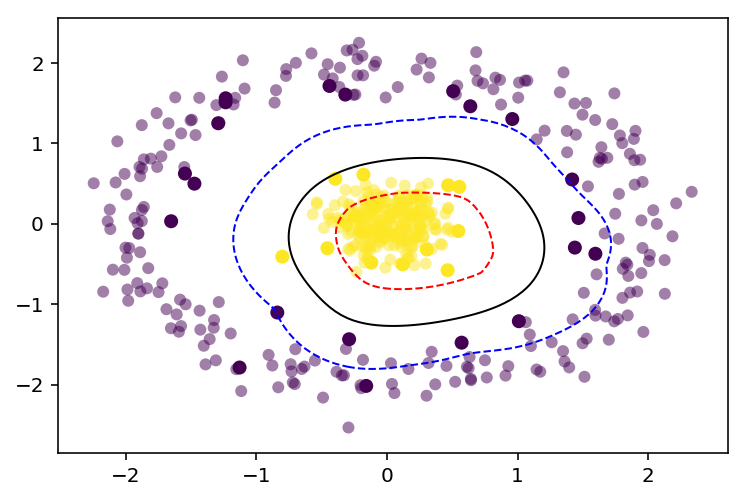

In [34]:
output = train(model)
fig, ax = plt.subplots()
grid, ax = plot_decision_boundary(output, ax)

In [37]:
# Set model parameters and initial values# Set mo 
C = 100.0
m = len(X_train_scaled)
initial_alphas = np.zeros(m)
initial_b = 0.0

# Instantiate model
model = SMOModel(X_train_scaled, y, C, gaussian_kernel,
                 initial_alphas, initial_b, np.zeros(m))

# Initialize error cache
initial_error = decision_function(model.alphas, model.y, model.kernel,
                                  model.X, model.X, model.b) - model.y
model.errors = initial_error

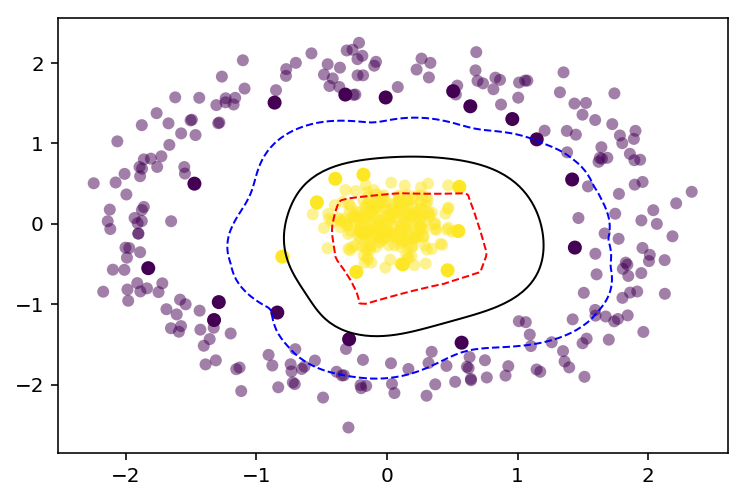

In [38]:
output = train(model)
fig, ax = plt.subplots()
grid, ax = plot_decision_boundary(output, ax)

# 实验三：高斯核参数调整

对于SVM的RBF核，我们主要的调参方法都是交叉验证，使用网格搜索来进行参数调整
我们将GridSearchCV类用于SVM RBF调参时要注意的参数有：

　　　　1) estimator :模型

　　　　2) param_grid：参数列表。 比如我们用SVC分类模型的话，那么param_grid可以定义为{"C":[0.1, 1, 10], "gamma": [0.1, 0.2, 0.3]}
　　　　3) cv: 训练集分成多少份来进行交叉验证

In [1]:
# 作者：爱夏<843573616@qq.com>
# 时间：2018年9月6日
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets, svm
from sklearn.svm import SVC
from sklearn.datasets import make_moons, make_circles, make_classification
%matplotlib inline

In [2]:
X, y = make_circles(noise=0.2, factor=0.5, random_state=1);
from sklearn.preprocessing import StandardScaler
X = StandardScaler().fit_transform(X)

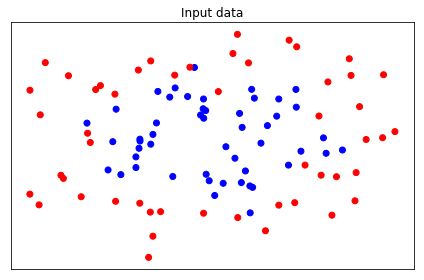

In [3]:
from matplotlib.colors import ListedColormap
cm = plt.cm.RdBu
cm_bright = ListedColormap(['#FF0000', '#0000FF'])
ax = plt.subplot()

ax.set_title("Input data")
# Plot the training points
ax.scatter(X[:, 0], X[:, 1], c=y, cmap=cm_bright)
ax.set_xticks(())
ax.set_yticks(())
plt.tight_layout()
plt.show()

In [4]:
from sklearn.model_selection import GridSearchCV
grid = GridSearchCV(SVC(), param_grid={"C":[0.1, 1, 10], "gamma": [1, 0.1, 0.01]}, cv=4)
grid.fit(X, y)
print("The best parameters are %s with a score of %0.2f"
      % (grid.best_params_, grid.best_score_))

The best parameters are {'C': 10, 'gamma': 0.1} with a score of 0.91


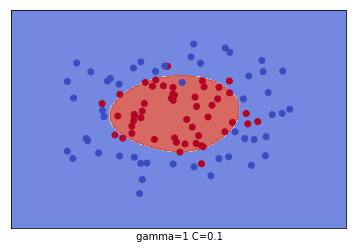

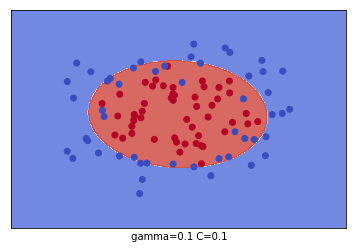

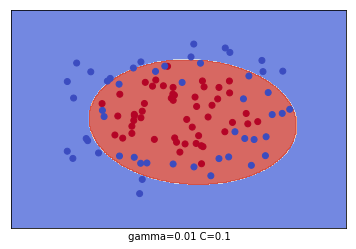

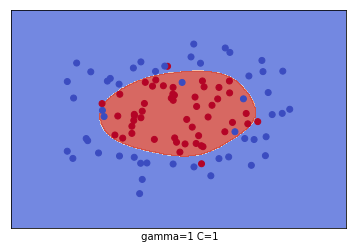

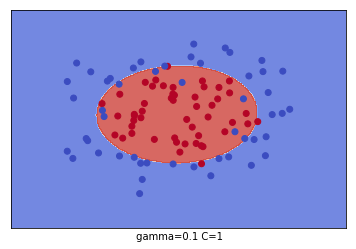

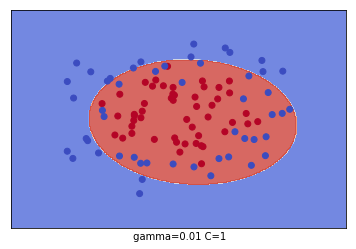

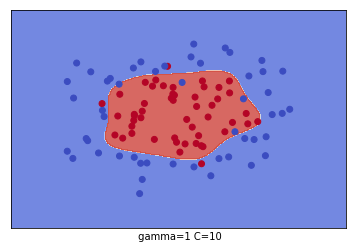

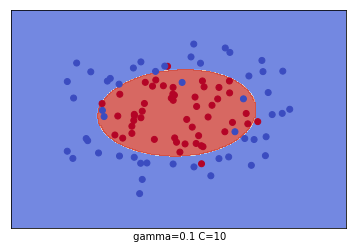

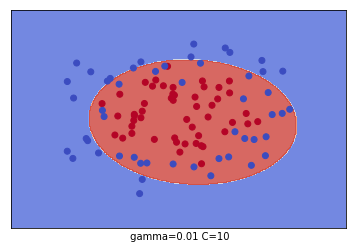

In [17]:
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max,0.02),
                     np.arange(y_min, y_max, 0.02))

for i, C in enumerate((0.1, 1, 10)):

    for j, gamma in enumerate((1, 0.1, 0.01)):
         
        plt.subplot()  
        clf = SVC(C=C, gamma=gamma)
        clf.fit(X,y)
        Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

        # Put the result into a color plot
        Z = Z.reshape(xx.shape)
        plt.contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.8)

        # Plot also the training points
        plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.coolwarm)

        plt.xlim(xx.min(), xx.max())
        plt.ylim(yy.min(), yy.max())
        plt.xticks(())
        plt.yticks(())
        plt.xlabel(" gamma=" + str(gamma) + " C=" + str(C))
        plt.show()


 SVM模型有两个非常重要的参数C与gamma。其中 C是惩罚系数，即对误差的宽容度。c越高，说明越不能容忍出现误差,容易过拟合。C越小，容易欠拟合。C过大或过小，泛化能力变差
gamma是选择RBF函数作为kernel后，该函数自带的一个参数。隐含地决定了数据映射到新的特征空间后的分布，gamma越大，支持向量越少，gamma值越小，支持向量越多。